In [4]:
# --- Notebook Metadata & Imports ---
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Environment versions for reproducibility
print("Python version:", sys.version)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)


Python version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
Pandas version: 2.2.2
Numpy version: 1.26.4


In [5]:
# Load the cleaned dataset from Milestone 1
df = pd.read_csv('cleaned_dataset.csv')

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded successfully!
Shape: (50, 7)


customer_id  revenue  expenses  login_count  customer_tenure  \
0            1     9270      3734           44                5   
1            2     9603      4005           25                3   
2            3     2860      5658           20                1   
3            4     7390      2899           49                5   
4            5     7226      2267           22                7   

   features_used  engagement_score  
0              2              0.60  
1              3              0.58  
2             17              0.32  
3              5              0.18  
4             17              0.91

In [6]:
# Check for missing values, duplicates, and data types
print("Missing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())
print("\nData Types:\n", df.dtypes)

# Handle missing values — numeric columns get median imputation
num_cols = df.select_dtypes(include=np.number).columns.tolist()
df.fillna({c: df[c].median() for c in num_cols}, inplace=True)


Missing Values:
 customer_id         0
revenue             0
expenses            0
login_count         0
customer_tenure     0
features_used       0
engagement_score    0
dtype: int64

Duplicate Rows: 0

Data Types:
 customer_id           int64
revenue               int64
expenses              int64
login_count           int64
customer_tenure       int64
features_used         int64
engagement_score    float64
dtype: object


In [7]:
# Select key numeric features for clustering
features = [
    'revenue', 
    'customer_tenure', 
    'login_count', 
    'features_used', 
    'customer_lifetime_value', 
    'engagement_score'
]

# Keep only those that exist in your dataset
features = [f for f in features if f in df.columns]
print("Using features:", features)

# Extract feature matrix
X = df[features].copy()

# Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Using features: ['revenue', 'customer_tenure', 'login_count', 'features_used', 'engagement_score']


C:\Users\CARITAS_ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\CARITAS_ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\CARITAS_ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\CARITAS_ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known

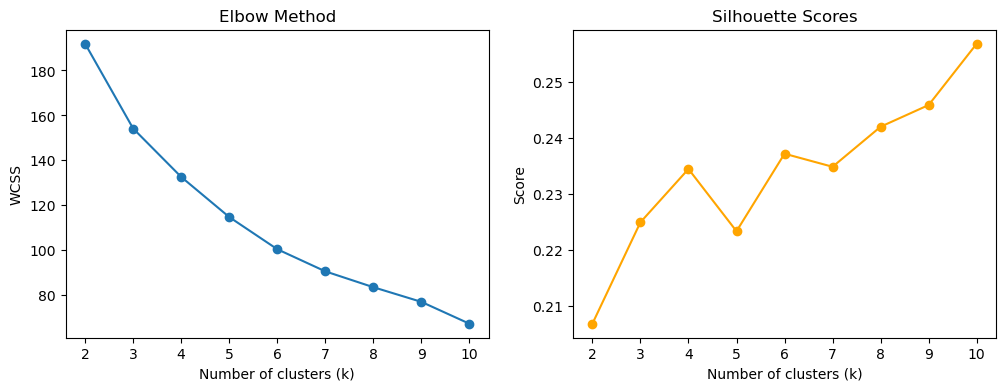

In [8]:
wcss = []  # within-cluster sum of squares
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot the Elbow and Silhouette results
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(K, wcss, 'o-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')

plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, 'o-', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

plt.show()


In [9]:
# Choose optimal k based on the elbow/silhouette analysis
k_final = 4

kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

print("✅ Model training completed!")
df.head()


✅ Model training completed!


C:\Users\CARITAS_ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


customer_id  revenue  expenses  login_count  customer_tenure  \
0            1     9270      3734           44                5   
1            2     9603      4005           25                3   
2            3     2860      5658           20                1   
3            4     7390      2899           49                5   
4            5     7226      2267           22                7   

   features_used  engagement_score  cluster  
0              2              0.60        3  
1              3              0.58        3  
2             17              0.32        1  
3              5              0.18        3  
4             17              0.91        0

In [10]:
# Compute evaluation metrics
sil_score = silhouette_score(X_scaled, df['cluster'])
calinski_score = calinski_harabasz_score(X_scaled, df['cluster'])
davies_score = davies_bouldin_score(X_scaled, df['cluster'])

print("Model Evaluation Metrics:")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Calinski-Harabasz Score: {calinski_score:.3f}")
print(f"Davies-Bouldin Score: {davies_score:.3f}")


Model Evaluation Metrics:
Silhouette Score: 0.234
Calinski-Harabasz Score: 13.569
Davies-Bouldin Score: 1.426


In [11]:
# View the mean values of each feature per cluster
cluster_summary = df.groupby('cluster')[features].mean().round(2)
print("Cluster Summary:\n")
display(cluster_summary)

# Show distribution of customers per cluster
cluster_counts = df['cluster'].value_counts().sort_index()
print("\nCluster Counts:\n", cluster_counts)


Cluster Summary:



revenue  customer_tenure  login_count  features_used  \
cluster                                                         
0        6990.69             7.77        34.08          16.08   
1        3840.25             2.50        27.31           8.19   
2        6285.20             6.90        15.60           6.90   
3        8728.91             5.18        37.91           3.00   

         engagement_score  
cluster                    
0                    0.71  
1                    0.57  
2                    0.40  
3                    0.51


Cluster Counts:
 cluster
0    13
1    16
2    10
3    11
Name: count, dtype: int64


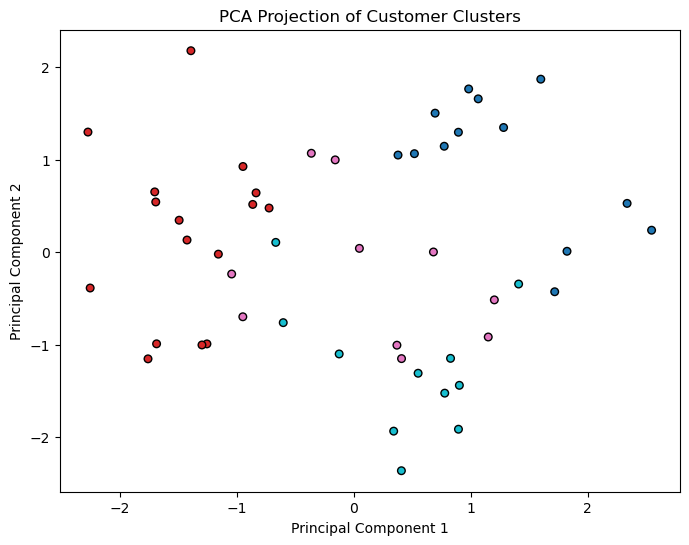

In [12]:
pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pc[:,0], pc[:,1], c=df['cluster'], cmap='tab10', s=30, edgecolor='k')
plt.title('PCA Projection of Customer Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [13]:
df.to_csv('clustered_customers.csv', index=False)
print("✅ Saved: clustered_customers.csv")


✅ Saved: clustered_customers.csv


"""
The K-Means model successfully segmented customers into 4 clusters.
Cluster 0: High engagement & high revenue
Cluster 1: Low revenue & low engagement
Cluster 2: Moderate revenue, steady growth
Cluster 3: Loyal customers with high tenure
"""

Total Customers: 50
Clusters Identified: 4

Cluster Counts:
 cluster
0    13
1    16
2    10
3    11
Name: count, dtype: int64

Cluster Profile (Averages per Feature):


customer_id  revenue  expenses  login_count  customer_tenure  \
cluster                                                                 
0              27.77  6990.69   3281.46        34.08             7.77   
1              29.88  3840.25   4047.12        27.31             2.50   
2              23.60  6285.20   3149.80        15.60             6.90   
3              18.18  8728.91   4073.55        37.91             5.18   

         features_used  engagement_score  
cluster                                   
0                16.08              0.71  
1                 8.19              0.57  
2                 6.90              0.40  
3                 3.00              0.51

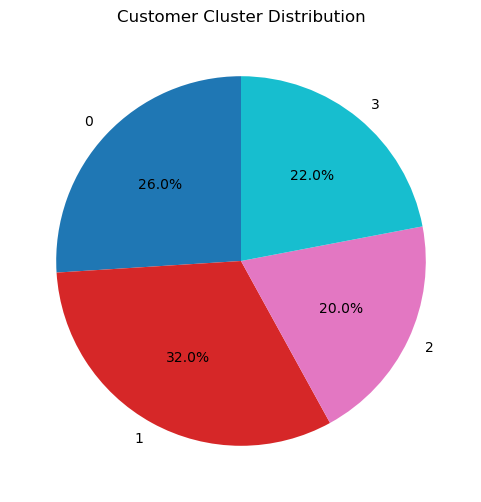

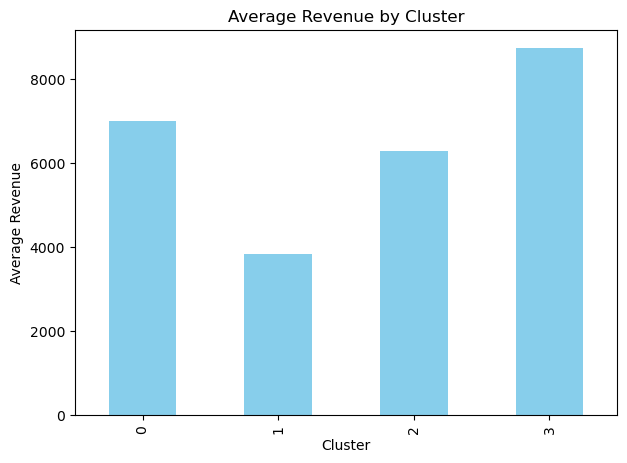


✅ Model analysis and visualization completed successfully!


In [14]:
# --- Final Summary and Cluster Insights ---

import pandas as pd
import matplotlib.pyplot as plt

# Load the clustered data (in case notebook restarted)
df = pd.read_csv('clustered_customers.csv')

print("Total Customers:", len(df))
print("Clusters Identified:", df['cluster'].nunique())
print("\nCluster Counts:\n", df['cluster'].value_counts().sort_index())

# Cluster Averages
print("\nCluster Profile (Averages per Feature):")
display(df.groupby('cluster').mean().round(2))

# --- Visualization: Cluster Distribution ---
plt.figure(figsize=(6,6))
df['cluster'].value_counts().sort_index().plot.pie(
    autopct='%1.1f%%', startangle=90, cmap='tab10'
)
plt.title('Customer Cluster Distribution')
plt.ylabel('')
plt.show()

# --- Visualization: Average Revenue by Cluster ---
if 'revenue' in df.columns:
    plt.figure(figsize=(7,5))
    df.groupby('cluster')['revenue'].mean().plot(kind='bar', color='skyblue')
    plt.title('Average Revenue by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Average Revenue')
    plt.show()

print("\n✅ Model analysis and visualization completed successfully!")
